# CM4044 Mini Project 1

## Gathering and Loading Dataset

The FastF1 dataset can be accessed through the FastF1 Python library. It provides detailed information for each race event, including lap-by-lap performance data, car telemetry, weather conditions, session results, and driver profiles. From the telemetry data, users can access time-synchronized variables such as speed, throttle, brake, DRS activation, track position (X, Y), and more. From each session, we are able to get every lap data for all drivers.

### Objective

To build a highly accurate predictive model for qualifying time by leveraging features that reflect straight and cornering performance of F1 drivers in 2025.

## Table of Contents
1. [Load and Prepare Formula 1 Race Sessions](#load-sessions)
2. [Data Pre-Processing](#data-preprocessing)
3. [Regression Models](#regression)
4. [Classification Models](#classification)

In [2]:
%pip install fastf1
import fastf1
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
import warnings
from pathlib import Path
import seaborn as sns
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
import datetime

%matplotlib inline
warnings.filterwarnings('ignore')
logging.getLogger('fastf1').setLevel(logging.WARNING)

fastf1.Cache.enable_cache(os.getcwd())

# Window size (range of the sliding window used in delta angle calculation)
N = 15

# Max and Min delta angle for a data point to be classified as being part of a corner
CORNER_THRESHOLD = 0.4

# Max speed for a data point to be classified as being part of a corner
SPEED_THRESHOLD = 200


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Load and Prepare Formula 1 Race Sessions <a name="load-sessions"></a>

In [4]:
year = 2025

schedule = fastf1.get_event_schedule(year)
gp_events = schedule[schedule['EventName'].str.contains("Grand Prix")]['EventName'].tolist()
gp_events = schedule[
    (schedule['EventName'].str.contains("Grand Prix")) &
    (schedule['EventDate'] <= datetime.datetime.now())
]['EventName'].tolist()

sessions = {}

#Loading race session
def load_session(event):
    try:
        session = fastf1.get_session(year, event, 'R')
        session.load(telemetry=True, laps=True, weather=True)
        return event, session
    except Exception as e:
        print(f"Cannot load {event}.")
        return None

with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {executor.submit(load_session, e): e for e in gp_events}
    for future in as_completed(futures):
        result = future.result()
        if result is not None:
            event, session = result
            sessions[event] = session

core        WARNING 	Fixed incorrect tyre stint information for driver '87'
core        WARNING 	Fixed incorrect tyre stint information for driver '30'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Driver 81 completed the race distance 00:00.036000 before the recorded end of the session.
core        WARNING 	Fixed incorrect tyre stint information for driver '81'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	

## Data Pre-processing <a name="data-preprocessing"></a>

### Compute Cornering and Telemetry Metrics for Each Race

In [3]:
race_stats = pd.DataFrame()
race_data = []

for event in gp_events:
    session = sessions[event]
    try:
        telemetry = session.laps.pick_driver('VER').get_telemetry()
    except Exception as e:
        print(f"Timing data not available for {event}")
        continue
    telemetry = telemetry[['X', 'Y','Speed']]

    dx1 = telemetry['X'] - telemetry['X'].shift(N)
    dy1 = telemetry['Y'] - telemetry['Y'].shift(N)
    dx2 = telemetry['X'].shift(-N) - telemetry['X']
    dy2 = telemetry['Y'].shift(-N) - telemetry['Y']

    telemetry['Event'] = event

    telemetry['Delta_Angle'] = np.arctan2(dx1*dy2 - dy1*dx2, dx1*dx2 + dy1*dy2)
    telemetry['Delta_Angle'] = telemetry['Delta_Angle'].fillna(0)

    telemetry['IsCorner'] = ((telemetry['Delta_Angle'] > CORNER_THRESHOLD) | (telemetry['Delta_Angle'] < -CORNER_THRESHOLD) | (telemetry['Speed'] < SPEED_THRESHOLD))

    race_data.append(telemetry)

race_stats = pd.concat(race_data, ignore_index=True)
race_stats.to_csv("race_stats.csv", index=False)

### Visualize Telemetry Data and Cornering Events

In [ ]:
race_stats_csv = pd.read_csv("race_stats.csv")

for event in race_stats_csv["Event"].unique():
    event_data = race_stats_csv[race_stats_csv["Event"] == event]

    plt.figure(figsize=(6.4, 4.8))
    cmap = sns.color_palette('viridis', as_cmap = True)
    norm = plt.Normalize(vmin=race_stats_csv['Delta_Angle'].min(), vmax=race_stats_csv['Delta_Angle'].max())

    sc = sns.scatterplot(data=event_data,
                        x='X', y='Y',
                        hue='Delta_Angle',
                        palette='viridis',
                        hue_norm=norm,
                        legend=False,
                        edgecolor=None)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax = plt.gca())

    plt.savefig(f"Race Track Viz/{event}_deltaAngle.png")
    plt.close()

    plt.figure(figsize=(6.4, 4.8))
    sns.scatterplot(data=event_data,
                    x='X', y='Y',
                    hue='IsCorner',
                    palette={False: "blue", True: "red"},
                    edgecolor=None)

    plt.savefig(f"Race Track Viz/{event}_isCorner.png")
    plt.close()

### Extract Driver Lap Statistics and Telemetry Metrics

In [68]:
year = 2025

schedule = fastf1.get_event_schedule(year)
gp_events = schedule[schedule['EventName'].str.contains("Grand Prix")]['EventName'].tolist()
gp_events = schedule[
    (schedule['EventName'].str.contains("Grand Prix")) &
    (schedule['EventDate'] <= datetime.datetime.now())
]['EventName'].tolist()

df = pd.DataFrame()
rows = []

def pick_median(laps):
    valid_laps = laps.dropna(subset=['LapTime']).reset_index(drop=True)
    if valid_laps.empty: return None
    times = valid_laps['LapTime'].dt.total_seconds()
    median_time = np.median(times)
    median_lap_index = (times - median_time).abs().argsort().iloc[0]
    return valid_laps.iloc[median_lap_index]

import requests
import pandas as pd
from bs4 import BeautifulSoup

url = "https://formulapedia.com/how-long-are-f1-races/"
track_info = {}

response = requests.get(url)

soup = BeautifulSoup(response.content, "html.parser")

tbl = soup.find("tbody")
row = tbl.find_all('tr')

for r in row:
    raceName = r.find('td', class_="column-1")
    circuitLength = r.find('td', class_="column-3")
    raceDistance = r.find('td', class_="column-4")
    numLaps = r.find('td', class_="column-5")

    track_info[raceName.text] = {"circuitLength": circuitLength.text.split("km")[0], "raceDistance": raceDistance.text.split("km")[0], "numLaps": numLaps.text}

track_info['Saudi Arabian Grand Prix'] = track_info.pop('Saudi Arabia Grand Prix')
track_info['Emilia Romagna Grand Prix'] = {"circuitLength": 4.909, "raceDistance": 309.267, "numLaps": 63}


In [73]:
for event in gp_events:
    session = sessions[event]
    weather = session.weather_data
    
    for num in session.drivers:
        driver = session.get_driver(num)['Abbreviation']
        team = session.get_driver(num)['TeamName']
        
        driver_laps_all = session.laps.pick_driver(driver)
        if driver_laps_all.empty:
            continue
        
        #TODO filter out wet weather laps
        #INCLUDES laps done under green flag conditions, EXCLUDES pit in, pit out laps, as well as first lap
        valid_laps = driver_laps_all[(driver_laps_all['TrackStatus'] == '1') 
                                        & (driver_laps_all['PitInTime'].isna()) 
                                        & (driver_laps_all['PitOutTime'].isna()) 
                                        & (driver_laps_all['LapNumber'] > 1)].dropna(subset=['LapTime', 'Time']).reset_index(drop=True)
        if valid_laps.empty: continue
        
        valid_laps['Time_Minute'] = valid_laps['Time'].dt.round('min')
        
        laps_with_weather = pd.merge_asof(
            valid_laps.sort_values('Time'),
            weather[['Time', 'AirTemp', 'TrackTemp']].sort_values('Time'),
            left_on='Time_Minute',
            right_on='Time',
            direction='nearest',
            suffixes=('_Lap', '_Weather')
        )
        
        for index, lap in laps_with_weather.iterrows():
            tyre_age = lap['TyreLife'] if 'TyreLife' in lap else lap['LapNumber'] - lap['StintStartLap']
            
            rows.append(
                {
                    "Driver": driver,
                    "Team": team,
                    "LapTimeSeconds": lap['LapTime'].total_seconds(),
                    
                    "TyreCompound": lap['Compound'],
                    "TyreAge": tyre_age,
                    "AirTemp": lap['AirTemp'],
                    "TrackTemp": lap['TrackTemp'],
                    
                    "TrackLength": track_info[event]["circuitLength"],
                    "RaceDistance": track_info[event]["raceDistance"],
                    "NumLaps": track_info[event]["numLaps"],
                    "LapNumber": lap['LapNumber'],
                 }
            )

df = pd.DataFrame(rows)

df.to_csv('f1.csv', index = False)

In [74]:
%pip install patsy
%pip install statsmodels
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv("f1.csv")
df.dropna(inplace=True)


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Data information

In [76]:
print(f"Shape: {df.shape}\n")
print(f"Size: {df.size}\n")
print(f"Driver distribution by {df.groupby('Team').size()}\n")
display(df.describe())

Shape: (16247, 11)

Size: 178717

Driver distribution by Team
Alpine             1523
Aston Martin       1545
Ferrari            1720
Haas F1 Team       1686
Kick Sauber        1620
McLaren            1730
Mercedes           1638
Racing Bulls       1631
Red Bull Racing    1632
Williams           1522
dtype: int64



,LapTimeSeconds,TyreAge,AirTemp,TrackTemp,TrackLength,RaceDistance,NumLaps,LapNumber
count,16247.000000,16247.000000,16247.000000,16247.000000,16247.000000,16247.000000,16247.000000,16247.000000
mean,88.046037,16.027821,24.029341,35.355924,5.057073,303.760640,61.629962,31.837508
std,11.143836,10.267329,4.730088,9.492108,0.859625,12.206905,9.162577,17.718751
min,67.924000,1.000000,14.200000,18.700000,3.337000,260.286000,44.000000,2.000000
25%,78.710500,8.000000,20.500000,27.900000,4.361000,306.049000,53.000000,17.000000
50%,84.202000,14.000000,24.100000,34.000000,5.063000,306.720000,61.000000,31.000000
75%,97.180000,22.000000,27.400000,43.400000,5.793000,308.238000,70.000000,45.000000
max,128.668000,71.000000,31.700000,50.400000,7.004000,309.267000,78.000000,78.000000


### Assess Multicollinearity in Telemetry Features

In [79]:
continuous_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
continuous_columns.remove("LapTimeSeconds")

# Check VIF (Multicolinearity)
formula = f'Q("LapTimeSeconds") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

            variable          VIF
0          Intercept  9852.404225
1       Q("TyreAge")     1.314710
2       Q("AirTemp")     2.824245
3     Q("TrackTemp")     3.446642
4   Q("TrackLength")    87.394732
5  Q("RaceDistance")     2.384923
6       Q("NumLaps")    81.452163
7     Q("LapNumber")     1.371674


In [80]:
# Check VIF again (Multicolinearity)
continuous_columns.remove("TrackLength")

formula = f'Q("LapTimeSeconds") ~ ' + ' + '.join([f'Q("{c}")' for c in continuous_columns])
Y, X = dmatrices(formula, data=df, return_type='dataframe')

vif_df = pd.DataFrame()
vif_df['variable'] = X.columns 
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

            variable          VIF
0          Intercept  1201.641173
1       Q("TyreAge")     1.314661
2       Q("AirTemp")     2.529200
3     Q("TrackTemp")     3.277334
4  Q("RaceDistance")     1.520003
5       Q("NumLaps")     1.953764
6     Q("LapNumber")     1.371286


## Build and Evaluate Machine Learning Models (Regression models) <a name="regression"></a>

In [95]:
x = df.drop(columns=['LapTimeSeconds'])
x = pd.get_dummies(x, columns=['Driver', 'Team', 'TyreCompound'], drop_first=True)
y = df['LapTimeSeconds']

modelval_df = pd.DataFrame(columns=['Model', 'R-Squared', 'RMSE'])

### Linear Regression

In [96]:
x_reduced = x.drop(columns=["TrackLength"])

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size=0.2, random_state=1)

model_lm = LinearRegression()
model_lm.fit(x_train, y_train)

y_pred_lm = model_lm.predict(x_test)

r2_lm = r2_score(y_test, y_pred_lm)
rmse_lm = np.sqrt(mean_squared_error(y_test, y_pred_lm))


modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'Linear Regression',
                                                     'R-Squared': r2_lm,
                                                     'RMSE': rmse_lm}])
                                                     ], ignore_index=True)

print(f"R-Squared: {r2_lm}")
print(f"RMSE: {rmse_lm}")

modelval_df = modelval_df.drop_duplicates()

R-Squared: 0.8277454209003412
RMSE: 4.643721741846821


### Random Forest Regressor

Best params: {'n_estimators': 35, 'min_samples_leaf': 1}
Test R-Squared: 0.9972721563469111
Test RMSE: 0.5843735330028403


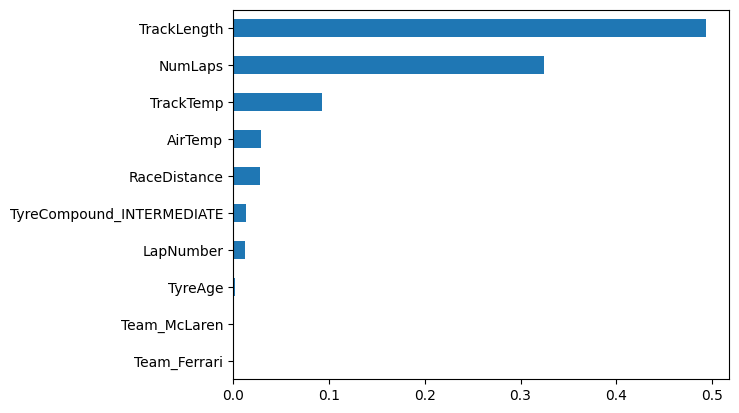

In [97]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

rf = RandomForestRegressor(random_state=1)

param_grid = {'n_estimators': list(range(31, 41)),
              'min_samples_leaf': list(range(1, 2))
              }

rand_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0,
    random_state=1
)

rand_search_rf.fit(x_train, y_train)

print("Best params:", rand_search_rf.best_params_)

best_rf = rand_search_rf.best_estimator_

y_pred = best_rf.predict(x_test)

r2_rf = r2_score(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))

modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'Random Forest Regression',
                                                     'R-Squared': r2_rf,
                                                     'RMSE': rmse_rf}])
                                                     ], ignore_index=True)

print(f"Test R-Squared: {r2_rf}")
print(f"Test RMSE: {rmse_rf}")

modelval_df = modelval_df.drop_duplicates()

importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
importances.sort_values().plot(kind='barh')
plt.show()

### XGBoost Regressor


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Best params: {'n_estimators': 735, 'learning_rate': 0.05}
R-Squared: 0.9972260924805791
RMSE: 0.5892869036071292


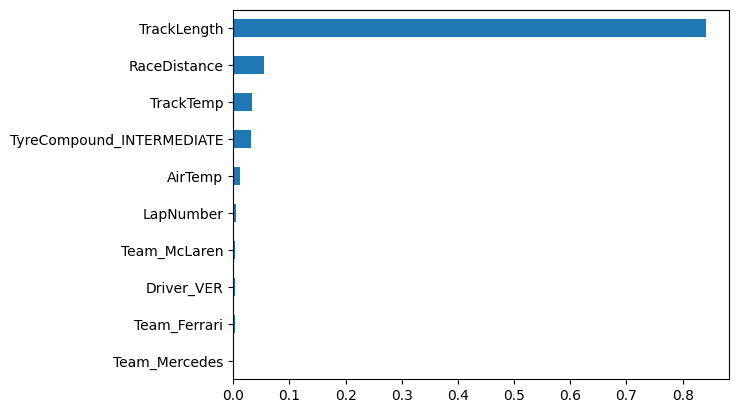

In [98]:
%pip install xgboost

import xgboost as xgb

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

xg = xgb.XGBRegressor(random_state=1)

param_grid = {"n_estimators": list(range(650, 750)),
              "learning_rate": [0.03, 0.035, 0.04, 0.045, 0.05]
              }

rand_search_xgb = RandomizedSearchCV(
    estimator=xg,
    param_distributions=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=0,
    random_state=1
)

rand_search_xgb.fit(x_train, y_train)

print("Best params:", rand_search_xgb.best_params_)

best_xgb = rand_search_xgb.best_estimator_

y_pred = rand_search_xgb.predict(x_test)

r2_xg = r2_score(y_test, y_pred)
rmse_xg = np.sqrt(mean_squared_error(y_test, y_pred))

modelval_df = pd.concat([modelval_df, pd.DataFrame([{'Model': 'XGBoost Regression',
                                                     'R-Squared': r2_xg,
                                                     'RMSE': rmse_xg}])
                                                     ], ignore_index=True)

print(f"R-Squared: {r2_xg}")
print(f"RMSE: {rmse_xg}")

modelval_df = modelval_df.drop_duplicates()

importances = pd.Series(best_xgb.feature_importances_, index=x_train.columns).sort_values(ascending=False).head(10)
importances.sort_values().plot(kind='barh')
plt.show()

,Model,R-Squared,RMSE
0,Linear Regression,0.827745,4.643722
1,Random Forest Regression,0.997272,0.584374
2,XGBoost Regression,0.997226,0.589287


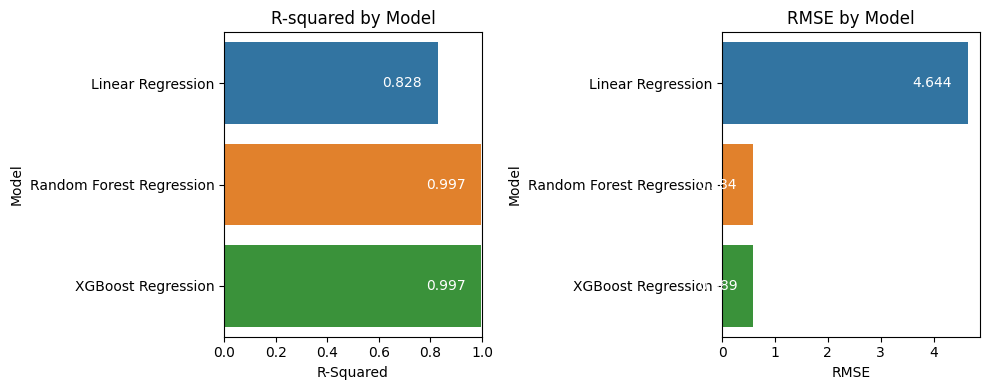

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

display(modelval_df)

sns.barplot(y='Model', x='R-Squared', data=modelval_df, ax=ax[0])
ax[0].set_title('R-squared by Model')
ax[0].set_xlim(0, 1)
for p in ax[0].patches:
    ax[0].annotate(
        format(p.get_width(), '.3f'),     
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),       
        textcoords='offset points'
    )

sns.barplot(y='Model', x='RMSE', data=modelval_df, ax=ax[1])
ax[1].set_title('RMSE by Model')
for p in ax[1].patches:
    ax[1].annotate(
        format(p.get_width(), '.3f'),
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=10, color='white',
        xytext=(-40, 0),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

## Build and Evaluate Machine Learning Models (Classification models) <a name="classification"></a>

In [8]:
df_c = pd.DataFrame()
rows = []

def pick_median(laps):
    valid_laps = laps.dropna(subset=['LapTime']).reset_index(drop=True)
    if valid_laps.empty: return None
    times = valid_laps['LapTime'].dt.total_seconds()
    median_time = np.median(times)
    median_lap_index = (times - median_time).abs().argsort().iloc[0]
    return valid_laps.iloc[median_lap_index]

for event in gp_events:
    session = sessions[event]
    weather = session.weather_data
    results = session.results
    
    for num in session.drivers:
        driver = session.get_driver(num)['Abbreviation']
        team = session.get_driver(num)['TeamName']
        position = results.loc[results['Abbreviation'] == driver, 'Position'].values[0]
        
        
        driver_laps_all = session.laps.pick_driver(driver)
        if driver_laps_all.empty:
            continue
        
        #TODO filter out wet weather laps
        driver_laps_race = driver_laps_all[( driver_laps_all['TrackStatus'] == '1') 
                                           & (driver_laps_all['PitInTime'].isna()) 
                                           & (driver_laps_all['PitOutTime'].isna()) 
                                           & (driver_laps_all['LapNumber'] > 1)].dropna(subset='LapTime').reset_index(drop=True)
        #INCLUDES laps done under green flag conditions, EXCLUDES pit in, pit out laps, as well as first lap
        
        lap_median = pick_median(driver_laps_race)
        lap_fastest = driver_laps_race.pick_fastest()
        if lap_median is None or lap_fastest is None: continue
        tel_median = lap_median.get_car_data()

        corner_speeds = tel_median.query('Speed < 200')['Speed']
        straight_speeds = tel_median.query('Speed >= 200')['Speed']

        #Getting TopSpeed with and without DRS
        top_speed = 0
        top_speed_no_drs = 0
        for _, lap in driver_laps_race.iterlaps():
            tel = lap.get_car_data()
            if 'Speed' in tel:
                lap_top_speed = tel['Speed'].max()
                if lap_top_speed > top_speed:
                    top_speed = lap_top_speed
            else:
                continue
            
            drs = tel['DRS'].values
            if 'Speed' in tel and drs.max() < 2: # looks for laps with no DRS enabled
                lap_top_speed = tel['Speed'].max()
                if lap_top_speed > top_speed_no_drs:
                    top_speed_no_drs = lap_top_speed
            else:
                continue

        drs_delta = top_speed - top_speed_no_drs
        #TODO add TopSpeed without drs and drs delta to df if needed

        rows.append(
            {
                "Driver": driver,
                "Team": team,
                "Event": event,
                "Position": position,
                "TyreCompound": lap_fastest['Compound'] if 'Compound' in lap_fastest else None,
                "QualifyingTime": lap_fastest['LapTime'].total_seconds() if lap_fastest['LapTime'] else None, 
                "TopSpeed": top_speed,
                "TopSpeedNoDelta": top_speed_no_drs,
                "AvgCornerSpeed": corner_speeds.mean() if not corner_speeds.empty else None,
                "AvgCornerEntrySpeed": corner_speeds.head(5).mean() if len(corner_speeds) >= 5 else None,
                "AvgCornerExitSpeed": corner_speeds.tail(5).mean() if len(corner_speeds) >= 5 else None,
                "AvgStraightSpeed": straight_speeds.mean()if not straight_speeds.empty else None,
                "AvgStraightEntrySpeed": straight_speeds.head(5).mean() if len(straight_speeds) >= 5 else None,
                "AvgStraightExitSpeed": straight_speeds.tail(5).mean() if len(straight_speeds) >= 5 else None,
                "ThrottleMean": tel_median['Throttle'].mean(),
                "ThrottleStdDev": tel_median['Throttle'].std(),
                "BrakeMean": tel_median['Brake'].mean(),
                "BrakeStdDev": tel_median['Brake'].std(),
                "DRSMean": tel_median['DRS'].mean(),
                # "DRSDelta": drs_delta
            }
        )

        
# df.at[i, 'AirTemp'] = weather['AirTemp']
# df.at[i, 'TrackTemp'] = weather['TrackTemp']
# df.at[i, 'Humidity'] = weather['Humidity']
# df.at[i, 'Pressure'] = weather['Pressure']
# df.at[i, 'Rainfall'] = weather['Rainfall']


df_c = pd.DataFrame(rows)

df_c.to_csv('f1_classification.csv', index = False)

Read "f1_classification.csv" into dataframe

In [10]:
df_c = pd.read_csv("f1_classification.csv")
df_c.dropna(inplace=True)

In [11]:
labels = []
median_straight = df_c['AvgStraightSpeed'].median()
median_corner = df_c['AvgCornerSpeed'].median()

std_straight = df_c['AvgStraightSpeed'].std()
std_corner = df_c['AvgCornerSpeed'].std()

threshold = 0.5

#TODO: EDIT GOOD AND BAD PARAMETERS FOR STRAIGHTS AND CORNERS
for _, row in df_c.iterrows():
        bool_straight = row['AvgStraightSpeed'] >= median_straight + threshold * std_straight
        bool_corner = row['AvgCornerSpeed'] >= median_corner + threshold * std_corner

        if bool_straight and not bool_corner:
            labels.append("Good in straights")
        elif not bool_straight and bool_corner:
            labels.append("Good in corners")
        elif bool_straight and bool_corner:
            labels.append("Good at both")
        else:
            labels.append("Bad at both")

### k-Nearest Neighbors

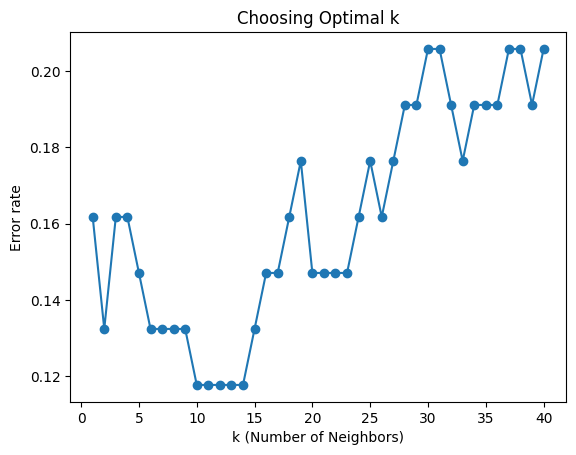

Best k: 10
Accuracy: 0.8823529411764706
F1: 0.8695024077046549
                   precision    recall  f1-score   support

      Bad at both       0.89      1.00      0.94        42
     Good at both       0.67      0.50      0.57         4
  Good in corners       1.00      0.43      0.60         7
Good in straights       0.87      0.87      0.87        15

         accuracy                           0.88        68
        macro avg       0.86      0.70      0.75        68
     weighted avg       0.89      0.88      0.87        68

[[42  0  0  0]
 [ 0  2  0  2]
 [ 3  1  3  0]
 [ 2  0  0 13]]
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}


In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

df_knn = df_c.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev"])

# x-axis for KNN
x = df_knn.drop(columns=['QualifyingTime', 'Driver', 'Team', 'Event', 'TyreCompound'])
selector = VarianceThreshold(threshold=0.01)
x_reduced = selector.fit_transform(x)

# y-axis for kNN
le = LabelEncoder()
y = le.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(x_reduced, y, test_size = 0.2, random_state = 1, stratify = y)

# Finding optimal k value
k_values = range(1, 41)   # Try k = 1 to 40
error_rate = []

p = 2

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k, p=p)
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    error_rate.append(np.mean(predictions != y_test))

best_k = error_rate.index(min(error_rate)) + 1

plt.plot(k_values, error_rate, marker='o')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Error rate")
plt.title("Choosing Optimal k")
plt.show()
print("Best k:", best_k)

#Run proper kNN
knn = KNeighborsClassifier(n_neighbors = best_k, p=p)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(knn.get_params())


In [118]:
print("y train: ", np.unique(y_train, return_counts=True))
print("y test: ", np.unique(y_test, return_counts=True))

y train:  (array([0, 1, 2, 3]), array([106,  21,  82,  66]))
y test:  (array([0, 1, 2, 3]), array([27,  5, 20, 17]))


### Support Vector Machine

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

df_svm = df_c.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev"])

# x-axis for SVM
x = df_svm.drop(columns=['QualifyingTime', 'Driver', 'Team', 'Event', 'TyreCompound'])
selector = VarianceThreshold(threshold=0.01)
x_reduced = selector.fit_transform(x)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_reduced)

#y-axis for SVM
y = LabelEncoder().fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 1, stratify = y)

#SVM
svm = SVC(kernel='poly', C=6)
svm.fit(x_train, y_train)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(svm.get_params())

Accuracy: 0.9117647058823529
F1: 0.901336898395722
                   precision    recall  f1-score   support

      Bad at both       0.91      1.00      0.95        42
     Good at both       0.75      0.75      0.75         4
  Good in corners       1.00      0.43      0.60         7
Good in straights       0.93      0.93      0.93        15

         accuracy                           0.91        68
        macro avg       0.90      0.78      0.81        68
     weighted avg       0.92      0.91      0.90        68

[[42  0  0  0]
 [ 0  3  0  1]
 [ 4  0  3  0]
 [ 0  1  0 14]]
{'C': 6, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


### Naive Bayes Classifier

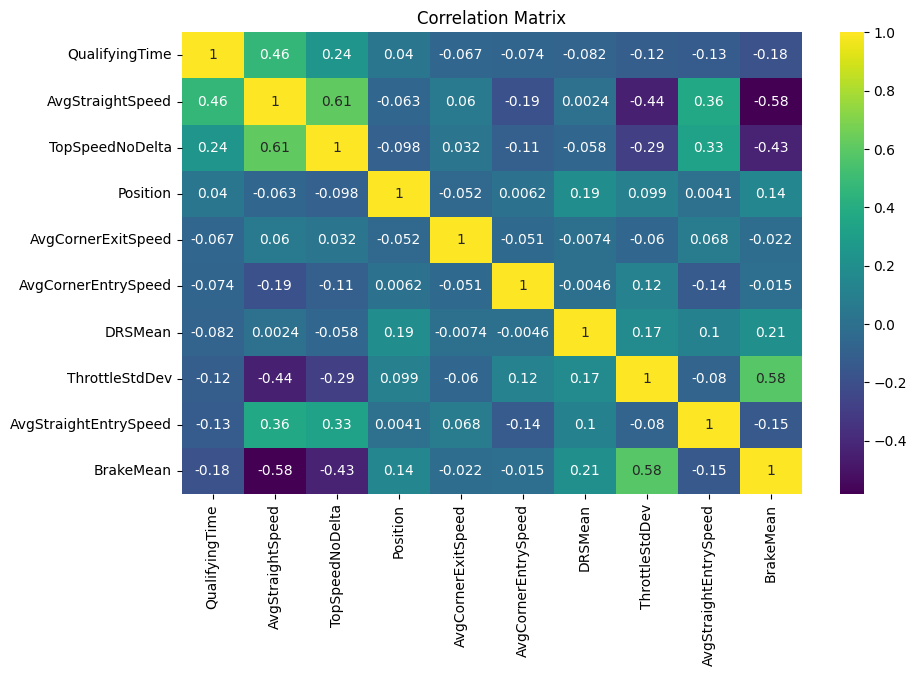

Accuracy: 0.8088235294117647
F1: 0.8214071069040643
                   precision    recall  f1-score   support

      Bad at both       0.90      0.83      0.86        42
     Good at both       0.75      0.75      0.75         4
  Good in corners       0.36      0.57      0.44         7
Good in straights       0.93      0.87      0.90        15

         accuracy                           0.81        68
        macro avg       0.73      0.76      0.74        68
     weighted avg       0.84      0.81      0.82        68

[[35  0  7  0]
 [ 0  3  0  1]
 [ 2  1  4  0]
 [ 2  0  0 13]]
{'priors': None, 'var_smoothing': 1e-09}


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

# TODO: Move corr map to data viz section + discuss suitability of NB model

# remove highly correlated columns
nb_df1 = df_c.drop(columns=["ThrottleMean", "TopSpeed", "AvgStraightExitSpeed", "BrakeStdDev"])

x = nb_df1.drop(columns=['QualifyingTime', 'Driver', 'Team', 'Event', 'TyreCompound'])
y_encoded = LabelEncoder().fit_transform(labels)

# ---quality correlation matrix---
numeric_df = nb_df1.select_dtypes(include=np.number)
k = len(numeric_df.columns) - 1 # number of variables for heatmap
cols = numeric_df.corr().nlargest(k, 'QualifyingTime')['QualifyingTime'].index #change QT 
cm = numeric_df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')
plt.title('Correlation Matrix')
plt.show()
plt.close()

# dividing data
# nb_df1_features = nb_df1.drop(['QualifyingTime', 'PerformanceCategory'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1, stratify=y
)

nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(nb.get_params())

### Logistic Regression

In [121]:
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1, stratify=y
)

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

y_pred = nb.predict(x_test)  #evaluate the classifier by score 
acc = metrics.accuracy_score(y_test, y_pred)

y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
conmat = confusion_matrix(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print("F1:", f1)
print(classification_report(y_test_labels, y_pred_labels))
print(conmat)
print(log_reg.get_params())

Accuracy: 0.8985507246376812
F1: 0.9014636602294386
                   precision    recall  f1-score   support

      Bad at both       0.93      0.93      0.93        27
     Good at both       0.62      1.00      0.77         5
  Good in corners       0.90      0.90      0.90        20
Good in straights       1.00      0.82      0.90        17

         accuracy                           0.90        69
        macro avg       0.86      0.91      0.87        69
     weighted avg       0.91      0.90      0.90        69

[[25  0  2  0]
 [ 0  5  0  0]
 [ 2  0 18  0]
 [ 0  3  0 14]]
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


### K Means

     Corner_cluster Driver             Team
178               0    ALO     Aston Martin
186               0    GAS           Alpine
185               0    BOR      Kick Sauber
184               0    COL           Alpine
183               0    TSU  Red Bull Racing
..              ...    ...              ...
318               4    OCO     Haas F1 Team
319               4    ALO     Aston Martin
320               4    HUL      Kick Sauber
311               4    NOR          McLaren
242               4    ALO     Aston Martin

[344 rows x 3 columns]

RMSE: 5.7932677704988285 

     Straight_cluster Driver             Team
0                   0    NOR          McLaren
273                 0    ALO     Aston Martin
272                 0    STR     Aston Martin
271                 0    BEA     Haas F1 Team
270                 0    ALB         Williams
..                ...    ...              ...
264                 4    GAS           Alpine
262                 4    TSU  Red Bull Racing
261   

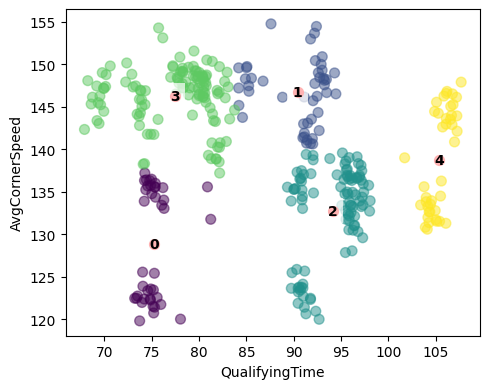

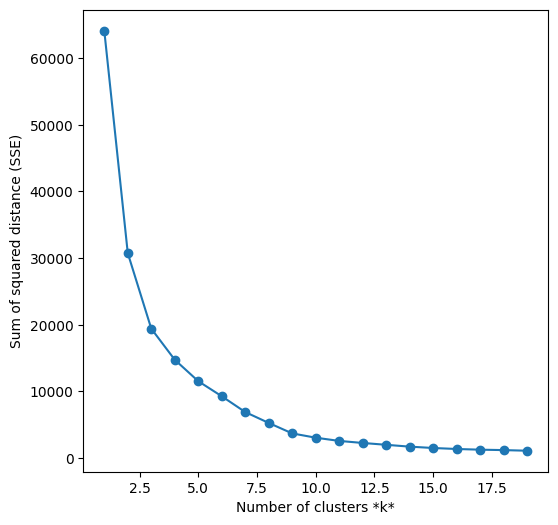

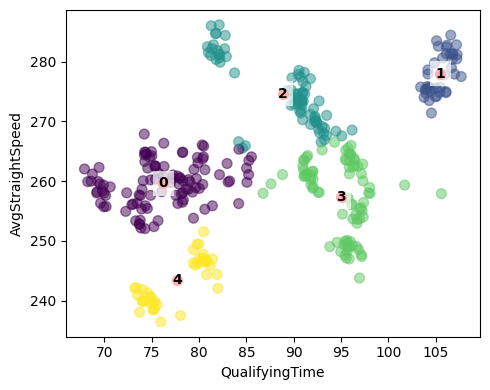

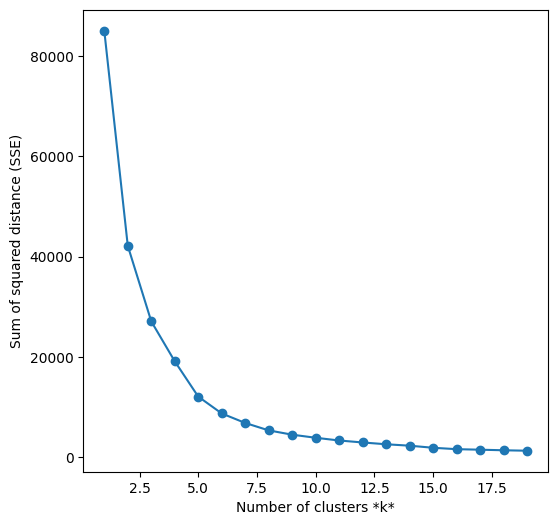

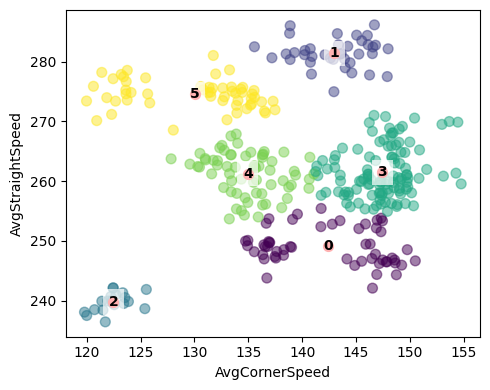

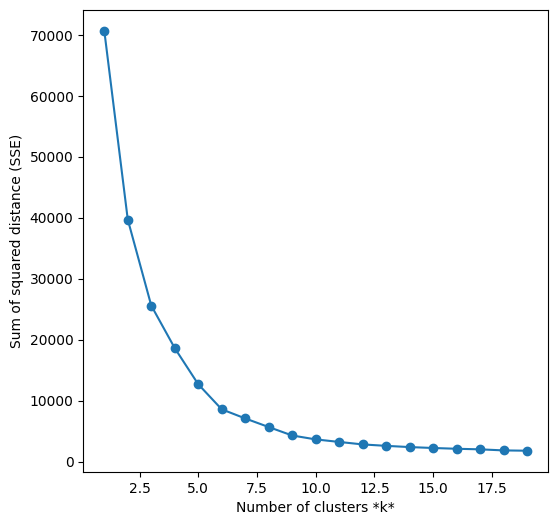

In [124]:
#k-means
from sklearn.cluster import KMeans

kmeans_df = df_c
x = kmeans_df['QualifyingTime']
hue1 = kmeans_df['Driver']

# ----data exploration---
plt.figure(figsize=(10,5))
plot1 = plt.subplot(1,2,1)
sns.scatterplot(x=x, y=kmeans_df['AvgCornerSpeed'], hue=hue1) #Corner speed plot
plot1.set_title('Avg Corner Speed')
# for i, driver in enumerate(df['Driver']): #label for driver for their respective dot
#     plot1.text(x.iloc[i]+0.05, df['AvgCornerSpeed'].iloc[i]+0.05, driver, fontsize=7)

plot2 = plt.subplot(1,2,2)
sns.scatterplot(x=x, y=kmeans_df['AvgStraightSpeed'], hue=hue1) #Straight speed plot
plot2.set_title('Avg Straight Speed')
# for i, driver in enumerate(df['Driver']): #label for driver for their respective dot
#     plot2.text(x.iloc[i]+0.05, df['AvgStraightSpeed'].iloc[i]+0.05, driver, fontsize=7)

# making common legend
handles, labels = plt.gca().get_legend_handles_labels()
plot1.get_legend().remove()
plot2.get_legend().remove()
plt.legend(handles, labels, title='Driver', loc='center left', bbox_to_anchor=(1.02, 0.5),
           fontsize=7, title_fontsize=8, markerscale=0.6, frameon=False)

plt.tight_layout()
plt.close()

# ---apply k-means clustering (CORNER SPEED)---
def kmeans_ml(feature1, feature2, cluster, n_clusters,):
    features = [feature1, feature2]
    X = kmeans_df[features]

    kmeans = KMeans(n_clusters=n_clusters, random_state=0) #change n clusters here
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # --accessing corner clusters---
    kmeans_df[cluster] = kmeans.labels_
    cluster_summary = kmeans_df[[cluster, 'Driver','Team']].copy()
    cluster_summary1 = cluster_summary.sort_values(by=cluster)
    print(cluster_summary1)
    # print("Corner speed clustering\n")
    # for cluster_id in sorted(df['Cluster_Corner'].unique()):
    #     cluster_drivers = df.loc[df['Cluster_Corner'] == cluster_id, 'Driver'].unique()
    #     print(f"Cluster {cluster_id+1}: {', '.join(cluster_drivers)}")

    # Compute RMSE manually
    squared_errors = np.sum((X - centroids[labels])**2, axis=1)
    cluster_rmse = np.sqrt(np.mean(squared_errors))
    print("\nRMSE:", cluster_rmse, '\n')

    fig, ax = plt.subplots(1,1,figsize=(5,4))

    # Plot also the training points
    ax.scatter(kmeans_df[feature1], kmeans_df[feature2], 
            c= kmeans.labels_.astype(float), s=50, alpha=0.5)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
    for i, (x_c, y_c) in enumerate(centroids):
        ax.text(x_c, y_c, f'{i}', color='black', fontsize=10, fontweight='bold', 
                ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)

    plt.tight_layout()

    sse = []
    list_k = list(range(1, 20))

    for k in list_k:
        km = KMeans(n_clusters=k, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)

    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance (SSE)');

    optimal_k = list_k[np.argmin(sse)]

kmeans_ml(feature1='QualifyingTime', feature2='AvgCornerSpeed', cluster='Corner_cluster', n_clusters=5)
# k = 4, RMSE: 7.104449474623985 
# k = 5, RMSE: 5.658441782468892 
# k = 6, RMSE: 5.205141483908022 
# Value of k = 5 is optimal for corner speed

kmeans_ml(feature1='QualifyingTime',feature2='AvgStraightSpeed', cluster='Straight_cluster', n_clusters=5)
# k = 4, RMSE: 7.325555946048033 
# k = 5, RMSE: 5.895425627708679 
# k = 6, RMSE: 5.033682884007996
# Value of k = 5 is optimal for straight speed

kmeans_ml(feature1='AvgCornerSpeed', feature2='AvgStraightSpeed', cluster='Corner_cluster', n_clusters=6)
# k = 5, RMSE: 6.085387112431213 
# k = 6, RMSE: 4.769617581476588 
# k = 7, RMSE: 4.298916330457035 
# Value of k = 6 is optimal for straight speed



### PCA

Explained variance ratio (all PCs): [0.07265698 0.05954308 0.05880681 0.05867927 0.05857292 0.05846502
 0.05818121 0.05509403 0.05070884 0.04249348 0.03378613 0.03124355]
Total variance (all PCs): 0.6382313079754979
Variance explained by PC1 and PC2: 0.1322


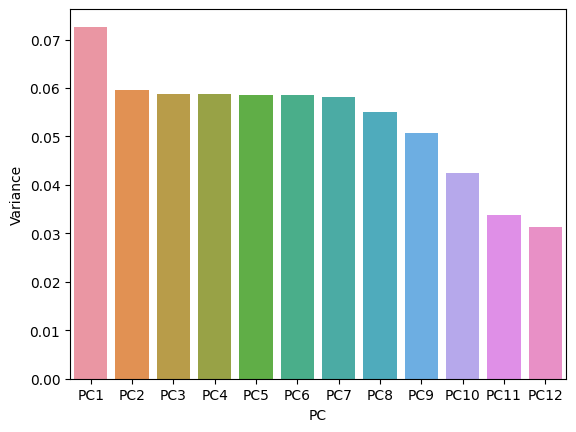

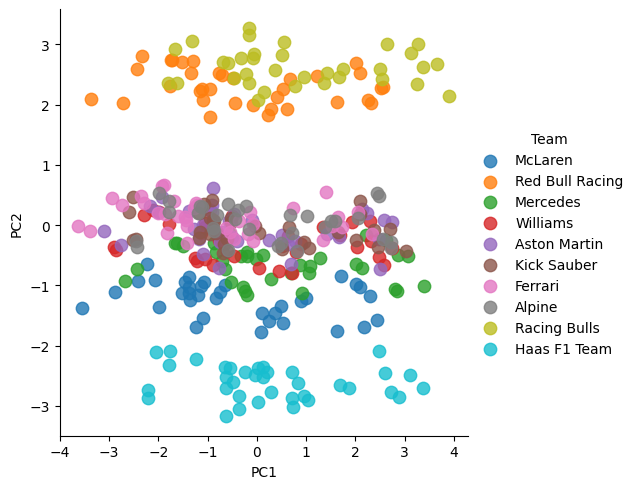

In [126]:
#PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# load dataset
# features = ['TopSpeed','QualifyingTime','AvgCornerSpeed','AvgCornerEntrySpeed','AvgCornerExitSpeed',
        #     'AvgStraightSpeed','AvgStraightEntrySpeed','AvgStraightExitSpeed']

x = df_c.drop(columns=["QualifyingTime"]) # Separating out the features
x = pd.get_dummies(x, columns=['Driver', 'Team'], drop_first=True)
x_scaled = StandardScaler().fit_transform(x) # Standardizing the features

def plot_pca(x, y, target,component_num=12, pc_x=1, pc_y=2):
        y = df_c[target] # Separating out the target
        pca = PCA(n_components=component_num)
        pc = pca.fit_transform(x)

        #2D table
        pc_cols = [f'PC{i+1}' for i in range(component_num)]
        pc_df = pd.DataFrame(data = pc , columns = pc_cols)
        pc_df[target] = y.values
        #print(pc_df.head()) #check

        print("Explained variance ratio (all PCs):",pca.explained_variance_ratio_)
        total_var = np.sum(pca.explained_variance_ratio_)
        print("Total variance (all PCs):", total_var)
        chosen_var = (pca.explained_variance_ratio_[pc_x-1] + 
                      pca.explained_variance_ratio_[pc_y-1])
        print(f"Variance explained by PC{pc_x} and PC{pc_y}: {chosen_var:.4f}")

        #Variance plot of all the PCs
        var_df = pd.DataFrame({
                'Variance':pca.explained_variance_ratio_,
                'PC':[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]})
        sns.barplot(x='PC',y="Variance", data=var_df)

        #PCA visualization
        pcx, pcy = f'PC{pc_x}', f'PC{pc_y}'
        sns.lmplot(x=pcx, y=pcy,
                data=pc_df, 
                fit_reg=False, 
                hue=target, # color by cluster
                legend=True,
                scatter_kws={"s": 80}) # specify the point size

plot_pca(x_scaled, y, target='Team',component_num=12, pc_x=1, pc_y=2) #change pc_x and pc_y value to change PC view